# Notebook 04 : Modèles de Classification
## 16 Algorithmes de Classification avec MLflow Tracking

---

### Algorithmes implémentés :

| # | Catégorie | Algorithme |
|---|-----------|------------|
| 1 | Base | K-Nearest Neighbors (KNN) |
| 2 | Base | Naive Bayes (Gaussian) |
| 3 | Base | Decision Tree (CART) |
| 4 | Linéaire | Logistic Regression |
| 5 | Linéaire | Linear SVM |
| 6 | Linéaire | Ridge Classifier |
| 7 | SVM Noyaux | SVM RBF Kernel |
| 8 | SVM Noyaux | SVM Polynomial Kernel |
| 9 | SVM Noyaux | SVM Linear Kernel |
| 10 | Ensemble | Random Forest |
| 11 | Ensemble | Extra Trees |
| 12 | Ensemble | AdaBoost |
| 13 | Ensemble | Gradient Boosting |
| 14 | Ensemble | XGBoost |
| 15 | Ensemble | LightGBM |
| 16 | Ensemble | Stacking Classifier |



## 1. Configuration et Imports

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Prétraitement
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Sklearn - Métriques
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Sklearn - Modèles de base
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Sklearn - Modèles linéaires
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC

# Sklearn - Ensemble
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    AdaBoostClassifier, GradientBoostingClassifier,
    StackingClassifier
)

# XGBoost et LightGBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# MLflow
import mlflow
import mlflow.sklearn

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Couleurs
COLORS = {'healthy': '#28A745', 'disease': '#DC3545', 'primary': '#2E86AB'}

print(f"Configuration terminée - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Configuration terminée - 2026-02-13 18:07:38


## 2. Configuration MLflow

In [2]:
# ============================================================================
# CONFIGURATION MLFLOW
# ============================================================================

mlflow.set_tracking_uri("file:./mlruns")
EXPERIMENT_NAME = "Heart_Disease_Classification"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow Experiment: {EXPERIMENT_NAME} (ID: {experiment_id})")

MLflow Experiment: Heart_Disease_Classification (ID: 487043277283511099)


## 3. Chargement et Préparation des Données

In [3]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================

df = pd.read_csv('heart.csv')
print(f"Dataset: {df.shape[0]} lignes x {df.shape[1]} colonnes")

# Séparation features/target
X = df.drop('target', axis=1)
y = df['target']
feature_names = X.columns.tolist()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape[0]} | Test: {X_test_scaled.shape[0]}")
print(f"Distribution target - Train: {dict(y_train.value_counts())}")

Dataset: 1025 lignes x 14 colonnes
Train: 820 | Test: 205
Distribution target - Train: {1: np.int64(421), 0: np.int64(399)}


## 4. Fonction d'Évaluation et Tracking

In [4]:
# ============================================================================
# FONCTION D'ÉVALUATION COMPLÈTE
# ============================================================================

def evaluate_and_log_model(model, model_name, X_train, X_test, y_train, y_test, params=None):
    """
    Entraîne, évalue et log un modèle dans MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        
        # Entraînement
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Prédictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Probabilités (si disponible)
        if hasattr(model, 'predict_proba'):
            y_proba_test = model.predict_proba(X_test)[:, 1]
            y_proba_train = model.predict_proba(X_train)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba_test = model.decision_function(X_test)
            y_proba_train = model.decision_function(X_train)
        else:
            y_proba_test = y_pred_test
            y_proba_train = y_pred_train
        
        # Métriques Train
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_precision = precision_score(y_train, y_pred_train)
        train_recall = recall_score(y_train, y_pred_train)
        train_f1 = f1_score(y_train, y_pred_train)
        train_roc_auc = roc_auc_score(y_train, y_proba_train)
        
        # Métriques Test
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_precision = precision_score(y_test, y_pred_test)
        test_recall = recall_score(y_test, y_pred_test)
        test_f1 = f1_score(y_test, y_pred_test)
        test_roc_auc = roc_auc_score(y_test, y_proba_test)
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        
        # Log paramètres
        mlflow.log_param("model_name", model_name)
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log métriques
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("train_roc_auc", train_roc_auc)
        
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("test_roc_auc", test_roc_auc)
        
        mlflow.log_metric("cv_mean", cv_scores.mean())
        mlflow.log_metric("cv_std", cv_scores.std())
        mlflow.log_metric("train_time", train_time)
        
        # Log modèle
        mlflow.sklearn.log_model(model, model_name)
        
        # Résultats
        results = {
            'model': model_name,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'roc_auc': test_roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'train_time': train_time,
            'y_pred': y_pred_test,
            'y_proba': y_proba_test,
            'confusion_matrix': cm
        }
        
        print(f"\u2705 {model_name}: Acc={test_accuracy:.4f}, F1={test_f1:.4f}, AUC={test_roc_auc:.4f}")
        
        return results, model

# Stockage des résultats
all_results = []
trained_models = {}

---

## 5. Modèles de Base (1-3)

In [5]:
print("="*70)
print("MODÈLES DE BASE")
print("="*70)

# 1. K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
results, model = evaluate_and_log_model(
    knn, "KNN", X_train_scaled, X_test_scaled, y_train, y_test,
    {'n_neighbors': 5, 'weights': 'uniform'}
)
all_results.append(results)
trained_models['KNN'] = model

# 2. Naive Bayes
nb = GaussianNB()
results, model = evaluate_and_log_model(
    nb, "Naive_Bayes", X_train_scaled, X_test_scaled, y_train, y_test,
    {'type': 'Gaussian'}
)
all_results.append(results)
trained_models['Naive_Bayes'] = model

# 3. Decision Tree
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    dt, "Decision_Tree", X_train_scaled, X_test_scaled, y_train, y_test,
    {'max_depth': 5, 'min_samples_split': 5}
)
all_results.append(results)
trained_models['Decision_Tree'] = model

MODÈLES DE BASE


2026/02/13 18:07:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ KNN: Acc=0.8634, F1=0.8654, AUC=0.9629


2026/02/13 18:07:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Naive_Bayes: Acc=0.8293, F1=0.8402, AUC=0.9043


2026/02/13 18:08:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Decision_Tree: Acc=0.8732, F1=0.8785, AUC=0.9326


## 6. Modèles Linéaires (4-6)

In [6]:
print("\n" + "="*70)
print("MODÈLES LINÉAIRES")
print("="*70)

# 4. Logistic Regression
lr = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    lr, "Logistic_Regression", X_train_scaled, X_test_scaled, y_train, y_test,
    {'C': 1.0, 'solver': 'lbfgs'}
)
all_results.append(results)
trained_models['Logistic_Regression'] = model

# 5. Linear SVM
linear_svm = LinearSVC(C=1.0, max_iter=10000, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    linear_svm, "Linear_SVM", X_train_scaled, X_test_scaled, y_train, y_test,
    {'C': 1.0, 'loss': 'squared_hinge'}
)
all_results.append(results)
trained_models['Linear_SVM'] = model

# 6. Ridge Classifier
ridge = RidgeClassifier(alpha=1.0, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    ridge, "Ridge_Classifier", X_train_scaled, X_test_scaled, y_train, y_test,
    {'alpha': 1.0}
)
all_results.append(results)
trained_models['Ridge_Classifier'] = model


MODÈLES LINÉAIRES


2026/02/13 18:08:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logistic_Regression: Acc=0.8098, F1=0.8312, AUC=0.9298


2026/02/13 18:08:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Linear_SVM: Acc=0.8049, F1=0.8276, AUC=0.9296


2026/02/13 18:08:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Ridge_Classifier: Acc=0.8049, F1=0.8291, AUC=0.9267


## 7. SVM avec Noyaux (7-9)

In [7]:
print("\n" + "="*70)
print("SVM AVEC NOYAUX")
print("="*70)

# 7. SVM RBF Kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    svm_rbf, "SVM_RBF", X_train_scaled, X_test_scaled, y_train, y_test,
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}
)
all_results.append(results)
trained_models['SVM_RBF'] = model

# 8. SVM Polynomial Kernel
svm_poly = SVC(kernel='poly', degree=3, C=1.0, probability=True, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    svm_poly, "SVM_Polynomial", X_train_scaled, X_test_scaled, y_train, y_test,
    {'kernel': 'poly', 'degree': 3, 'C': 1.0}
)
all_results.append(results)
trained_models['SVM_Polynomial'] = model

# 9. SVM Linear Kernel
svm_linear = SVC(kernel='linear', C=1.0, probability=True, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    svm_linear, "SVM_Linear", X_train_scaled, X_test_scaled, y_train, y_test,
    {'kernel': 'linear', 'C': 1.0}
)
all_results.append(results)
trained_models['SVM_Linear'] = model


SVM AVEC NOYAUX


2026/02/13 18:08:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ SVM_RBF: Acc=0.9268, F1=0.9296, AUC=0.9771


2026/02/13 18:08:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ SVM_Polynomial: Acc=0.9268, F1=0.9315, AUC=0.9806


2026/02/13 18:08:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ SVM_Linear: Acc=0.8146, F1=0.8362, AUC=0.9249


## 8. Méthodes d'Ensemble (10-15)

In [8]:
print("\n" + "="*70)
print("MÉTHODES D'ENSEMBLE")
print("="*70)

# 10. Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    rf, "Random_Forest", X_train_scaled, X_test_scaled, y_train, y_test,
    {'n_estimators': 100, 'max_depth': 10}
)
all_results.append(results)
trained_models['Random_Forest'] = model

# 11. Extra Trees
et = ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    et, "Extra_Trees", X_train_scaled, X_test_scaled, y_train, y_test,
    {'n_estimators': 100, 'max_depth': 10}
)
all_results.append(results)
trained_models['Extra_Trees'] = model

# 12. AdaBoost
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    ada, "AdaBoost", X_train_scaled, X_test_scaled, y_train, y_test,
    {'n_estimators': 100, 'learning_rate': 0.1}
)
all_results.append(results)
trained_models['AdaBoost'] = model

# 13. Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    gb, "Gradient_Boosting", X_train_scaled, X_test_scaled, y_train, y_test,
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
)
all_results.append(results)
trained_models['Gradient_Boosting'] = model


MÉTHODES D'ENSEMBLE


2026/02/13 18:09:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Random_Forest: Acc=1.0000, F1=1.0000, AUC=1.0000


2026/02/13 18:09:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Extra_Trees: Acc=0.9902, F1=0.9906, AUC=1.0000


2026/02/13 18:09:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ AdaBoost: Acc=0.8780, F1=0.8837, AUC=0.9373


2026/02/13 18:09:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Gradient_Boosting: Acc=0.9756, F1=0.9763, AUC=0.9876


In [9]:
# 14. XGBoost
xgb = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3,
    use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE
)
results, model = evaluate_and_log_model(
    xgb, "XGBoost", X_train_scaled, X_test_scaled, y_train, y_test,
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
)
all_results.append(results)
trained_models['XGBoost'] = model

# 15. LightGBM
lgbm = LGBMClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3,
    random_state=RANDOM_STATE, verbose=-1
)
results, model = evaluate_and_log_model(
    lgbm, "LightGBM", X_train_scaled, X_test_scaled, y_train, y_test,
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
)
all_results.append(results)
trained_models['LightGBM'] = model

2026/02/13 18:09:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ XGBoost: Acc=0.9756, F1=0.9761, AUC=0.9868


2026/02/13 18:09:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ LightGBM: Acc=0.9561, F1=0.9577, AUC=0.9909


## 9. Stacking Classifier (16)

In [10]:
print("\n" + "="*70)
print("STACKING CLASSIFIER")
print("="*70)

# 16. Stacking
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, 
                          eval_metric='logloss', random_state=RANDOM_STATE, verbosity=0)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))
]

stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5
)

results, model = evaluate_and_log_model(
    stacking, "Stacking", X_train_scaled, X_test_scaled, y_train, y_test,
    {'base_models': 'RF+XGB+SVM', 'final_estimator': 'LogisticRegression'}
)
all_results.append(results)
trained_models['Stacking'] = model

print(f"\n\u2705 Total: {len(all_results)} modèles entraînés et trackés dans MLflow")


STACKING CLASSIFIER


2026/02/13 18:10:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Stacking: Acc=0.9707, F1=0.9717, AUC=0.9962

✅ Total: 16 modèles entraînés et trackés dans MLflow


---

## 10. Tableau Comparatif

In [11]:
# ============================================================================
# TABLEAU COMPARATIF
# ============================================================================

print("="*70)
print("TABLEAU COMPARATIF DES 16 MODÈLES")
print("="*70)

# Créer le DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['model'],
    'Train Acc': r['train_accuracy'],
    'Test Acc': r['test_accuracy'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1-Score': r['f1_score'],
    'ROC-AUC': r['roc_auc'],
    'CV Mean': r['cv_mean'],
    'CV Std': r['cv_std'],
    'Time (s)': r['train_time']
} for r in all_results])

# Trier par Test Accuracy
comparison_df = comparison_df.sort_values('Test Acc', ascending=False).reset_index(drop=True)

# Afficher
display(comparison_df.style.format({
    'Train Acc': '{:.4f}',
    'Test Acc': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'ROC-AUC': '{:.4f}',
    'CV Mean': '{:.4f}',
    'CV Std': '{:.4f}',
    'Time (s)': '{:.4f}'
}).background_gradient(subset=['Test Acc', 'F1-Score', 'ROC-AUC'], cmap='RdYlGn'))

TABLEAU COMPARATIF DES 16 MODÈLES


,Model,Train Acc,Test Acc,Precision,Recall,F1-Score,ROC-AUC,CV Mean,CV Std,Time (s)
0,Random_Forest,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9805,0.0194,0.3069
1,Extra_Trees,0.9976,0.9902,0.9813,1.0000,0.9906,1.0000,0.9854,0.0099,0.1583
2,Gradient_Boosting,0.9902,0.9756,0.9717,0.9810,0.9763,0.9876,0.9634,0.0168,0.2600
3,XGBoost,0.9902,0.9756,0.9808,0.9714,0.9761,0.9868,0.9488,0.0119,0.5483
4,Stacking,0.9915,0.9707,0.9626,0.9810,0.9717,0.9962,0.9659,0.0147,2.3194
5,LightGBM,0.9866,0.9561,0.9444,0.9714,0.9577,0.9909,0.9488,0.0203,0.2252
6,SVM_RBF,0.9561,0.9268,0.9167,0.9429,0.9296,0.9771,0.8951,0.0151,0.0823
7,SVM_Polynomial,0.9415,0.9268,0.8947,0.9714,0.9315,0.9806,0.9159,0.0141,0.0529
8,AdaBoost,0.8732,0.8780,0.8636,0.9048,0.8837,0.9373,0.8488,0.0226,0.2310
9,Decision_Tree,0.9293,0.8732,0.8624,0.8952,0.8785,0.9326,0.8988,0.0217,0.0184


In [12]:
# Top 5 modèles
print("\nTOP 5 MODÈLES (par Test Accuracy):")
print("-"*50)
for i, row in comparison_df.head(5).iterrows():
    print(f"{i+1}. {row['Model']}: Acc={row['Test Acc']:.4f}, F1={row['F1-Score']:.4f}, AUC={row['ROC-AUC']:.4f}")


TOP 5 MODÈLES (par Test Accuracy):
--------------------------------------------------
1. Random_Forest: Acc=1.0000, F1=1.0000, AUC=1.0000
2. Extra_Trees: Acc=0.9902, F1=0.9906, AUC=1.0000
3. Gradient_Boosting: Acc=0.9756, F1=0.9763, AUC=0.9876
4. XGBoost: Acc=0.9756, F1=0.9761, AUC=0.9868
5. Stacking: Acc=0.9707, F1=0.9717, AUC=0.9962


## 11. Visualisation - Comparaison des Métriques

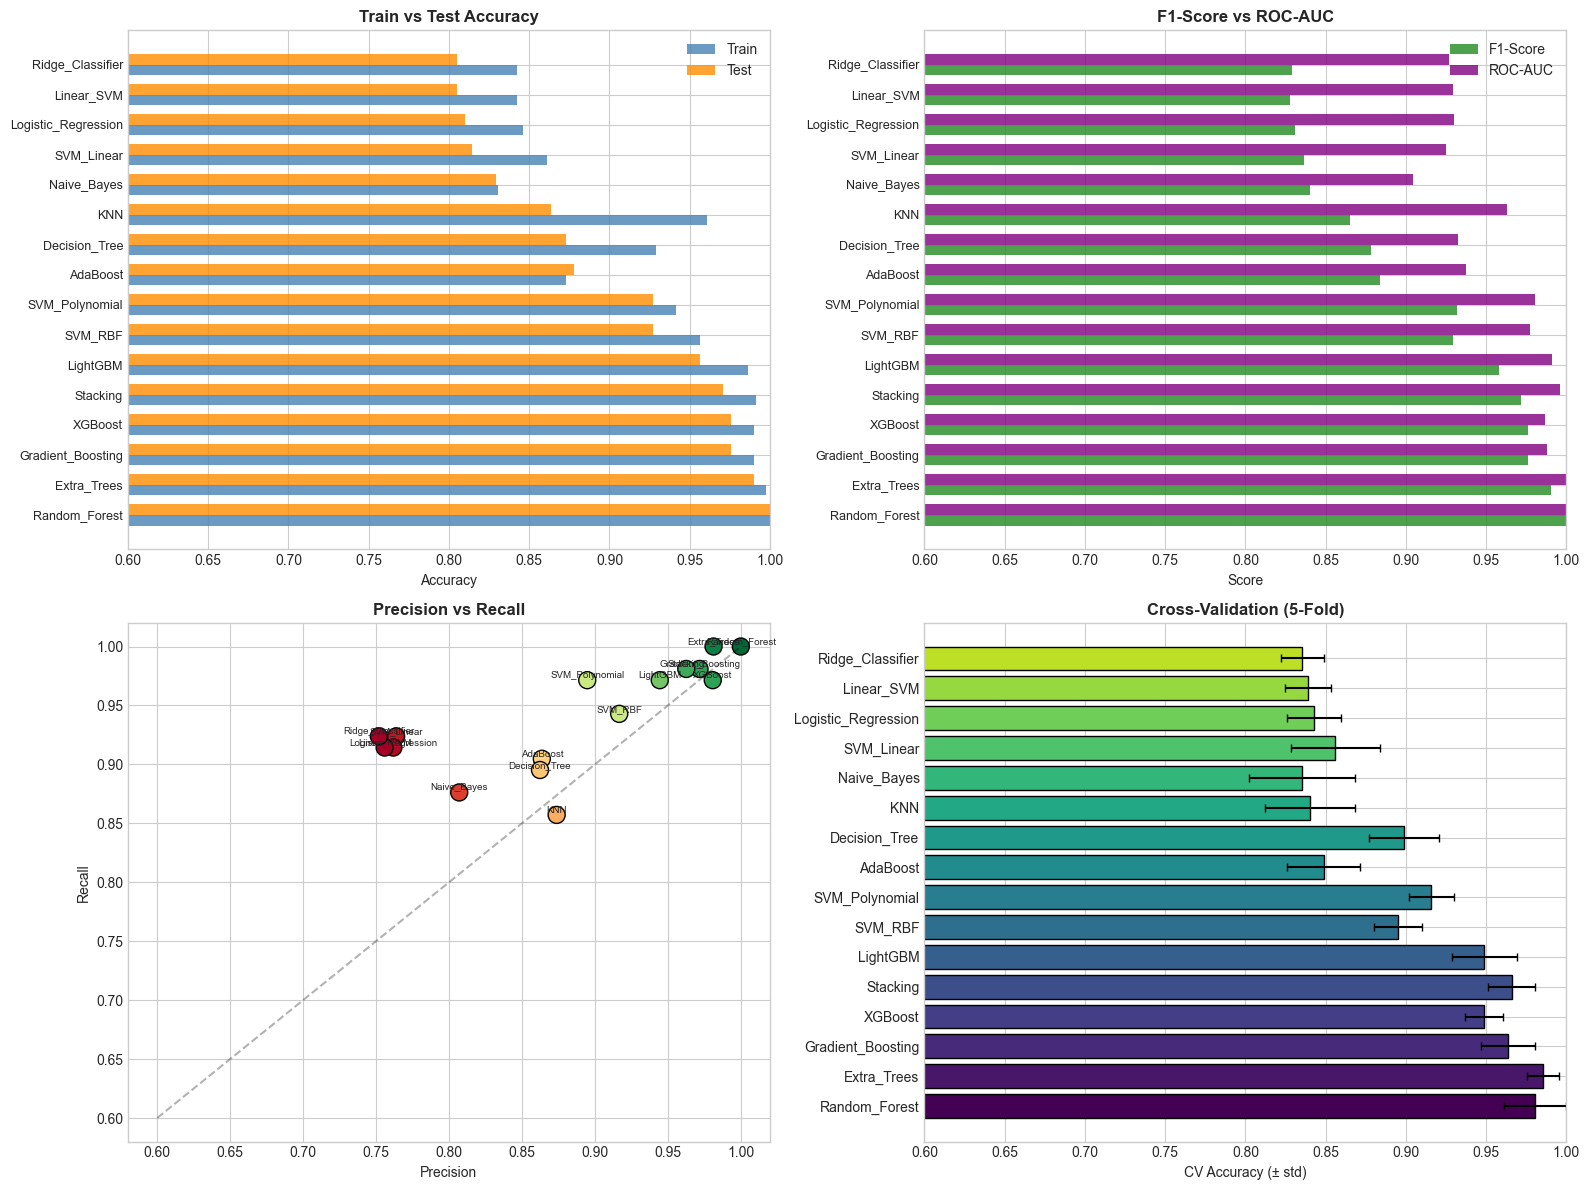

In [13]:
# ============================================================================
# VISUALISATION COMPARATIVE
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df['Model'].tolist()
colors = plt.cm.viridis(np.linspace(0, 0.9, len(models)))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
x = np.arange(len(models))
width = 0.35
ax1.barh(x - width/2, comparison_df['Train Acc'], width, label='Train', color='steelblue', alpha=0.8)
ax1.barh(x + width/2, comparison_df['Test Acc'], width, label='Test', color='darkorange', alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(models, fontsize=9)
ax1.set_xlabel('Accuracy')
ax1.set_title('Train vs Test Accuracy', fontweight='bold')
ax1.legend()
ax1.set_xlim(0.6, 1.0)

# 2. F1-Score & ROC-AUC
ax2 = axes[0, 1]
ax2.barh(x - width/2, comparison_df['F1-Score'], width, label='F1-Score', color='forestgreen', alpha=0.8)
ax2.barh(x + width/2, comparison_df['ROC-AUC'], width, label='ROC-AUC', color='purple', alpha=0.8)
ax2.set_yticks(x)
ax2.set_yticklabels(models, fontsize=9)
ax2.set_xlabel('Score')
ax2.set_title('F1-Score vs ROC-AUC', fontweight='bold')
ax2.legend()
ax2.set_xlim(0.6, 1.0)

# 3. Precision vs Recall
ax3 = axes[1, 0]
ax3.scatter(comparison_df['Precision'], comparison_df['Recall'], 
            c=comparison_df['Test Acc'], cmap='RdYlGn', s=150, edgecolor='black')
for i, model in enumerate(models):
    ax3.annotate(model, (comparison_df['Precision'].iloc[i], comparison_df['Recall'].iloc[i]),
                 fontsize=7, ha='center', va='bottom')
ax3.set_xlabel('Precision')
ax3.set_ylabel('Recall')
ax3.set_title('Precision vs Recall', fontweight='bold')
ax3.plot([0.6, 1], [0.6, 1], 'k--', alpha=0.3)

# 4. Cross-Validation
ax4 = axes[1, 1]
ax4.barh(models, comparison_df['CV Mean'], xerr=comparison_df['CV Std'], 
         color=colors, edgecolor='black', capsize=3)
ax4.set_xlabel('CV Accuracy (± std)')
ax4.set_title('Cross-Validation (5-Fold)', fontweight='bold')
ax4.set_xlim(0.6, 1.0)

plt.tight_layout()
plt.savefig('images/classification_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Confusion Matrices

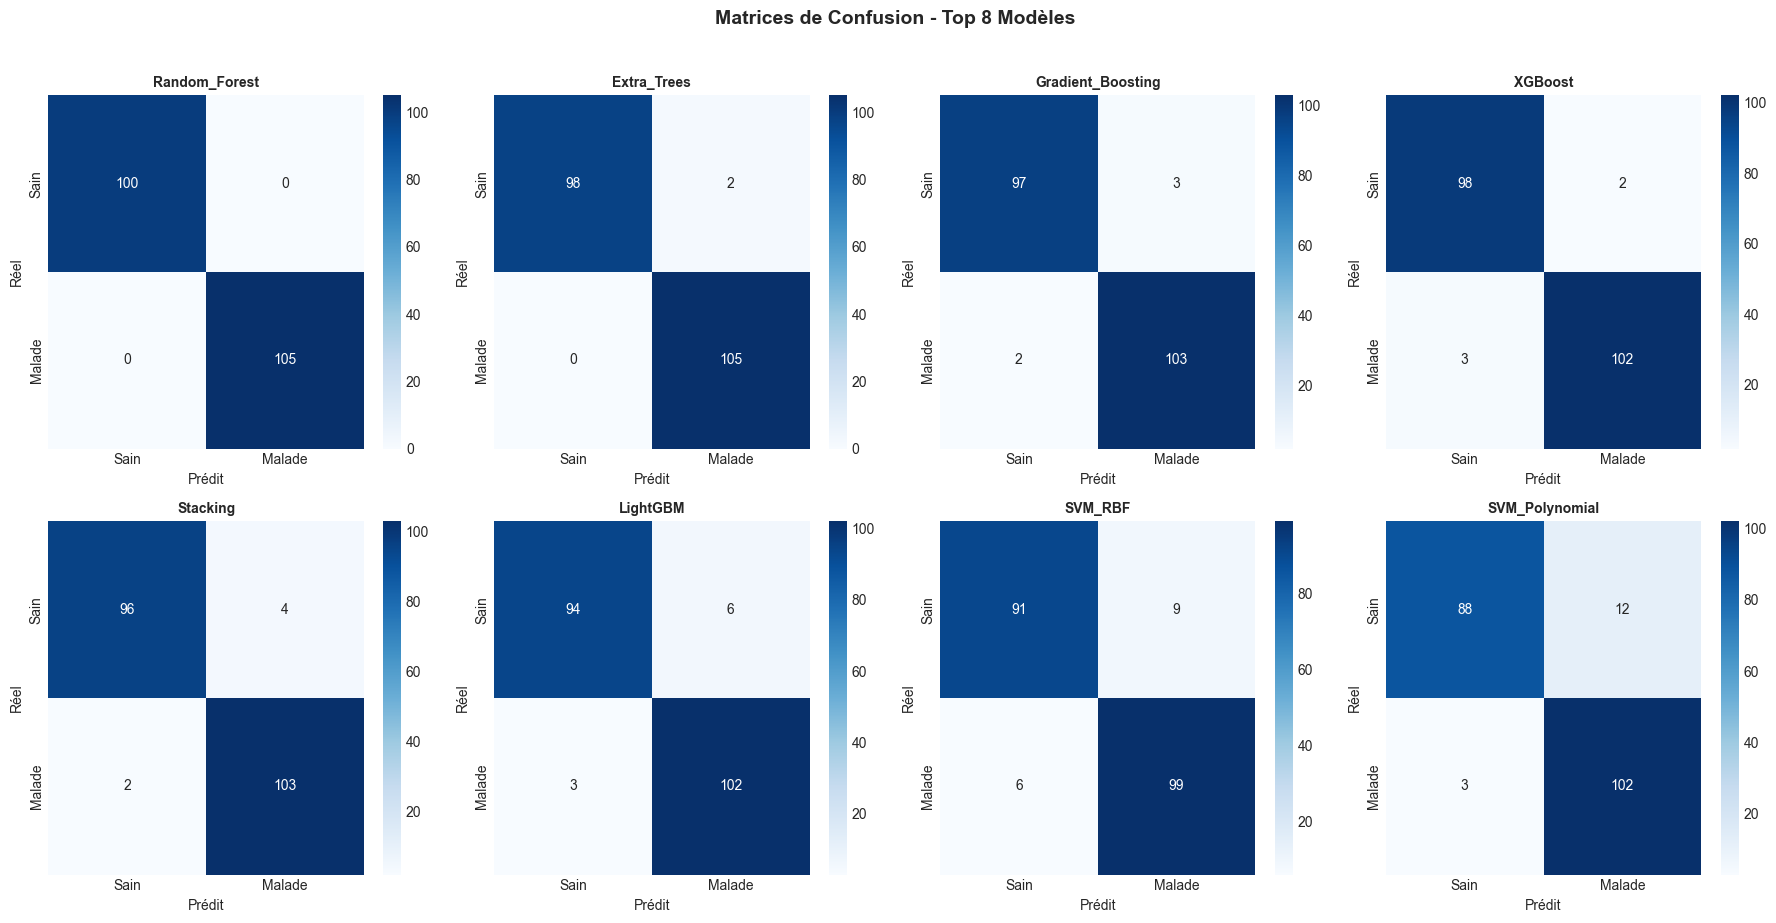

In [14]:
# ============================================================================
# CONFUSION MATRICES - TOP 8 MODÈLES
# ============================================================================

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

top_8_models = comparison_df.head(8)['Model'].tolist()

for idx, model_name in enumerate(top_8_models):
    ax = axes[idx]
    
    # Trouver la confusion matrix
    cm = next(r['confusion_matrix'] for r in all_results if r['model'] == model_name)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Sain', 'Malade'], yticklabels=['Sain', 'Malade'])
    ax.set_title(f'{model_name}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Réel')

plt.suptitle('Matrices de Confusion - Top 8 Modèles', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Courbes ROC

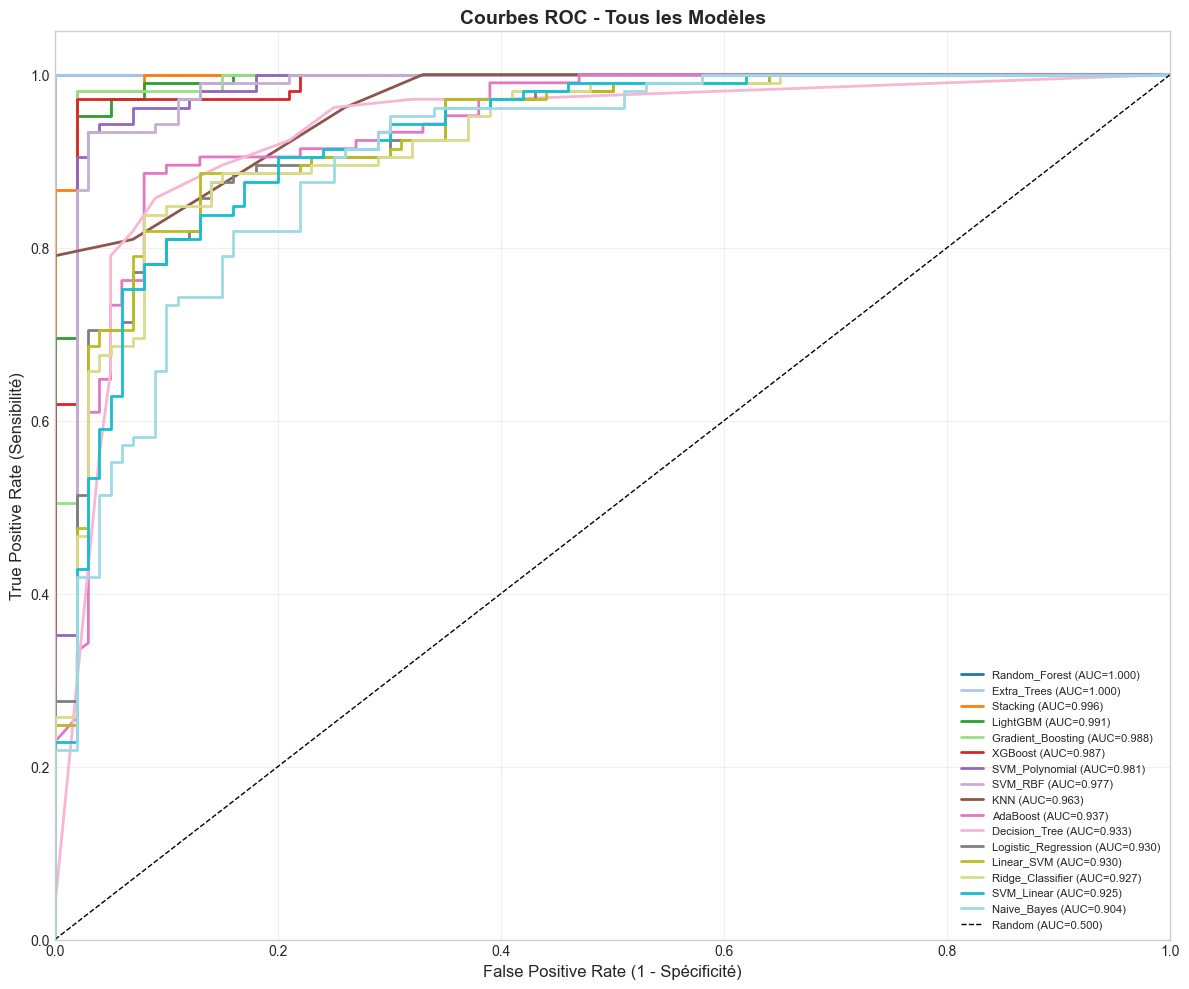

In [15]:
# ============================================================================
# COURBES ROC - TOUS LES MODÈLES
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.cm.tab20(np.linspace(0, 1, len(all_results)))

for idx, result in enumerate(sorted(all_results, key=lambda x: x['roc_auc'], reverse=True)):
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    auc = result['roc_auc']
    ax.plot(fpr, tpr, color=colors[idx], linewidth=2,
            label=f"{result['model']} (AUC={auc:.3f})")

# Ligne diagonale
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC=0.500)')

ax.set_xlabel('False Positive Rate (1 - Spécificité)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensibilité)', fontsize=12)
ax.set_title('Courbes ROC - Tous les Modèles', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/roc_curves_all.png', dpi=300, bbox_inches='tight')
plt.show()

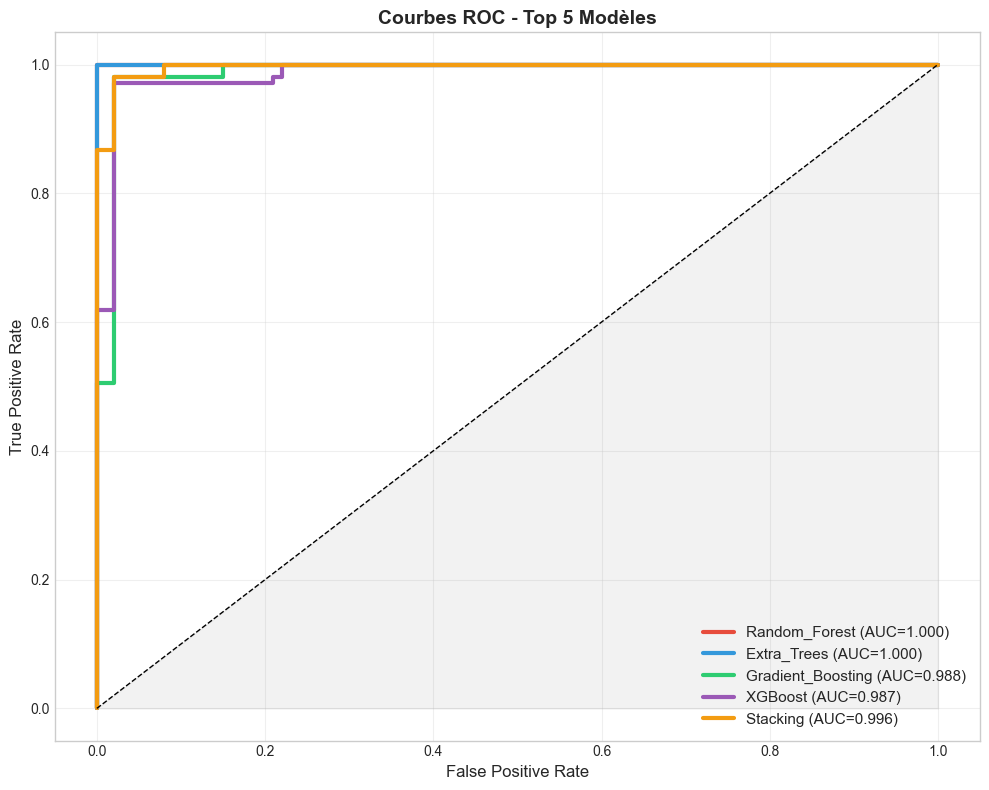

In [16]:
# ============================================================================
# COURBES ROC - TOP 5 MODÈLES
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

top_5_names = comparison_df.head(5)['Model'].tolist()
top_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6', '#F39C12']

for idx, model_name in enumerate(top_5_names):
    result = next(r for r in all_results if r['model'] == model_name)
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    auc = result['roc_auc']
    ax.plot(fpr, tpr, color=top_colors[idx], linewidth=3,
            label=f"{model_name} (AUC={auc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Courbes ROC - Top 5 Modèles', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/roc_curves_top5.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Feature Importance (Modèles Ensemble)

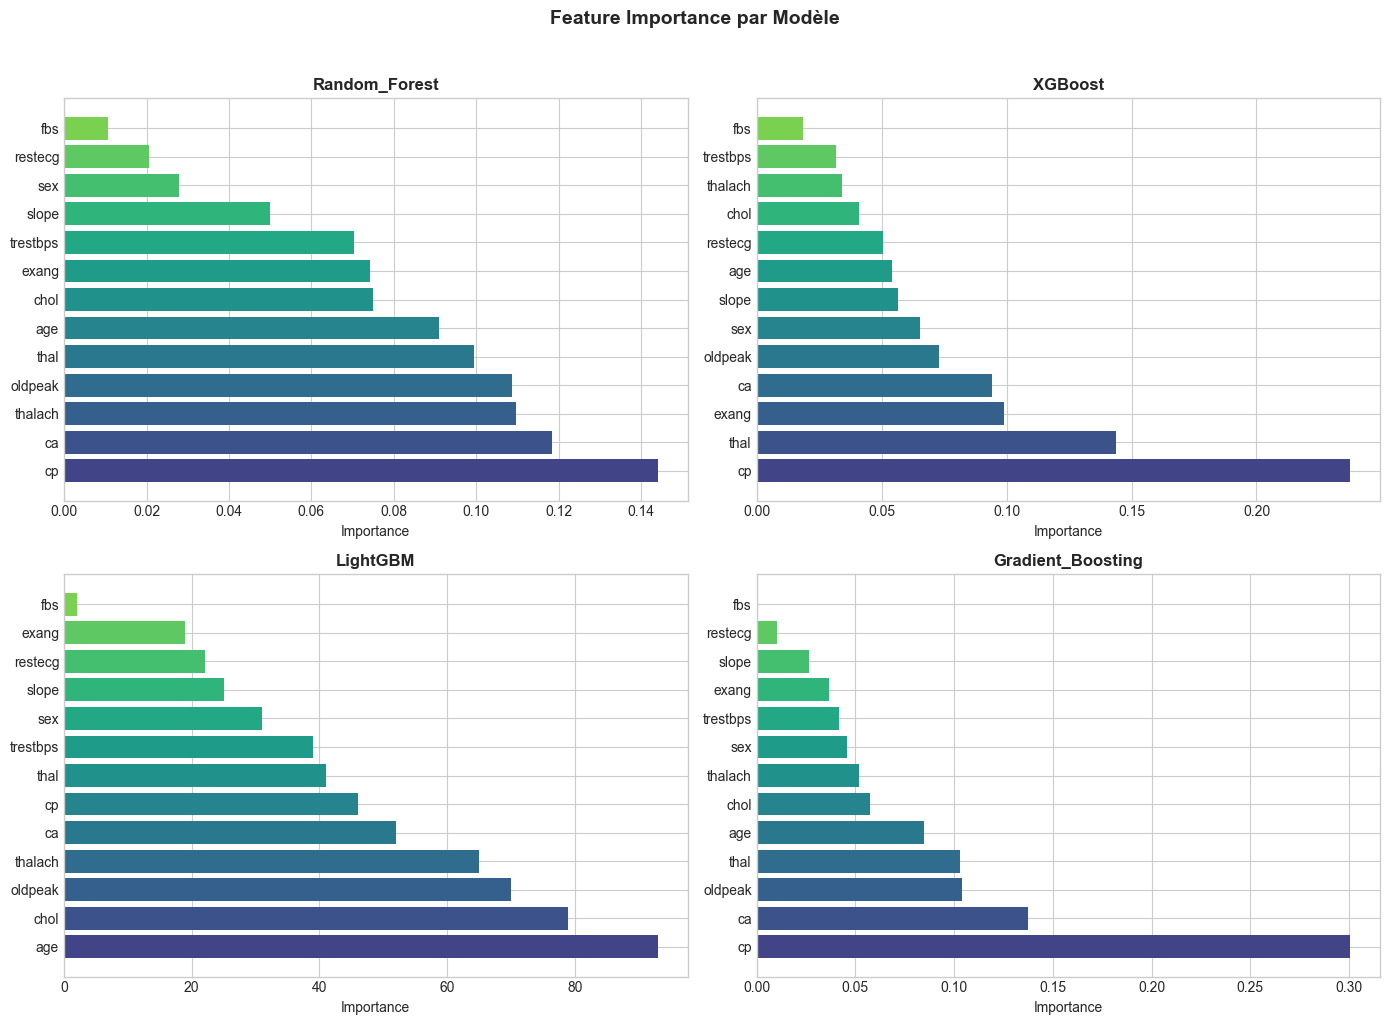

In [17]:
# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

importance_models = [
    ('Random_Forest', trained_models['Random_Forest']),
    ('XGBoost', trained_models['XGBoost']),
    ('LightGBM', trained_models['LightGBM']),
    ('Gradient_Boosting', trained_models['Gradient_Boosting'])
]

for idx, (name, model) in enumerate(importance_models):
    ax = axes[idx // 2, idx % 2]
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_names)))
    ax.barh([feature_names[i] for i in indices], importances[indices], color=colors)
    ax.set_xlabel('Importance')
    ax.set_title(f'{name}', fontweight='bold')

plt.suptitle('Feature Importance par Modèle', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 15. Dashboard Final

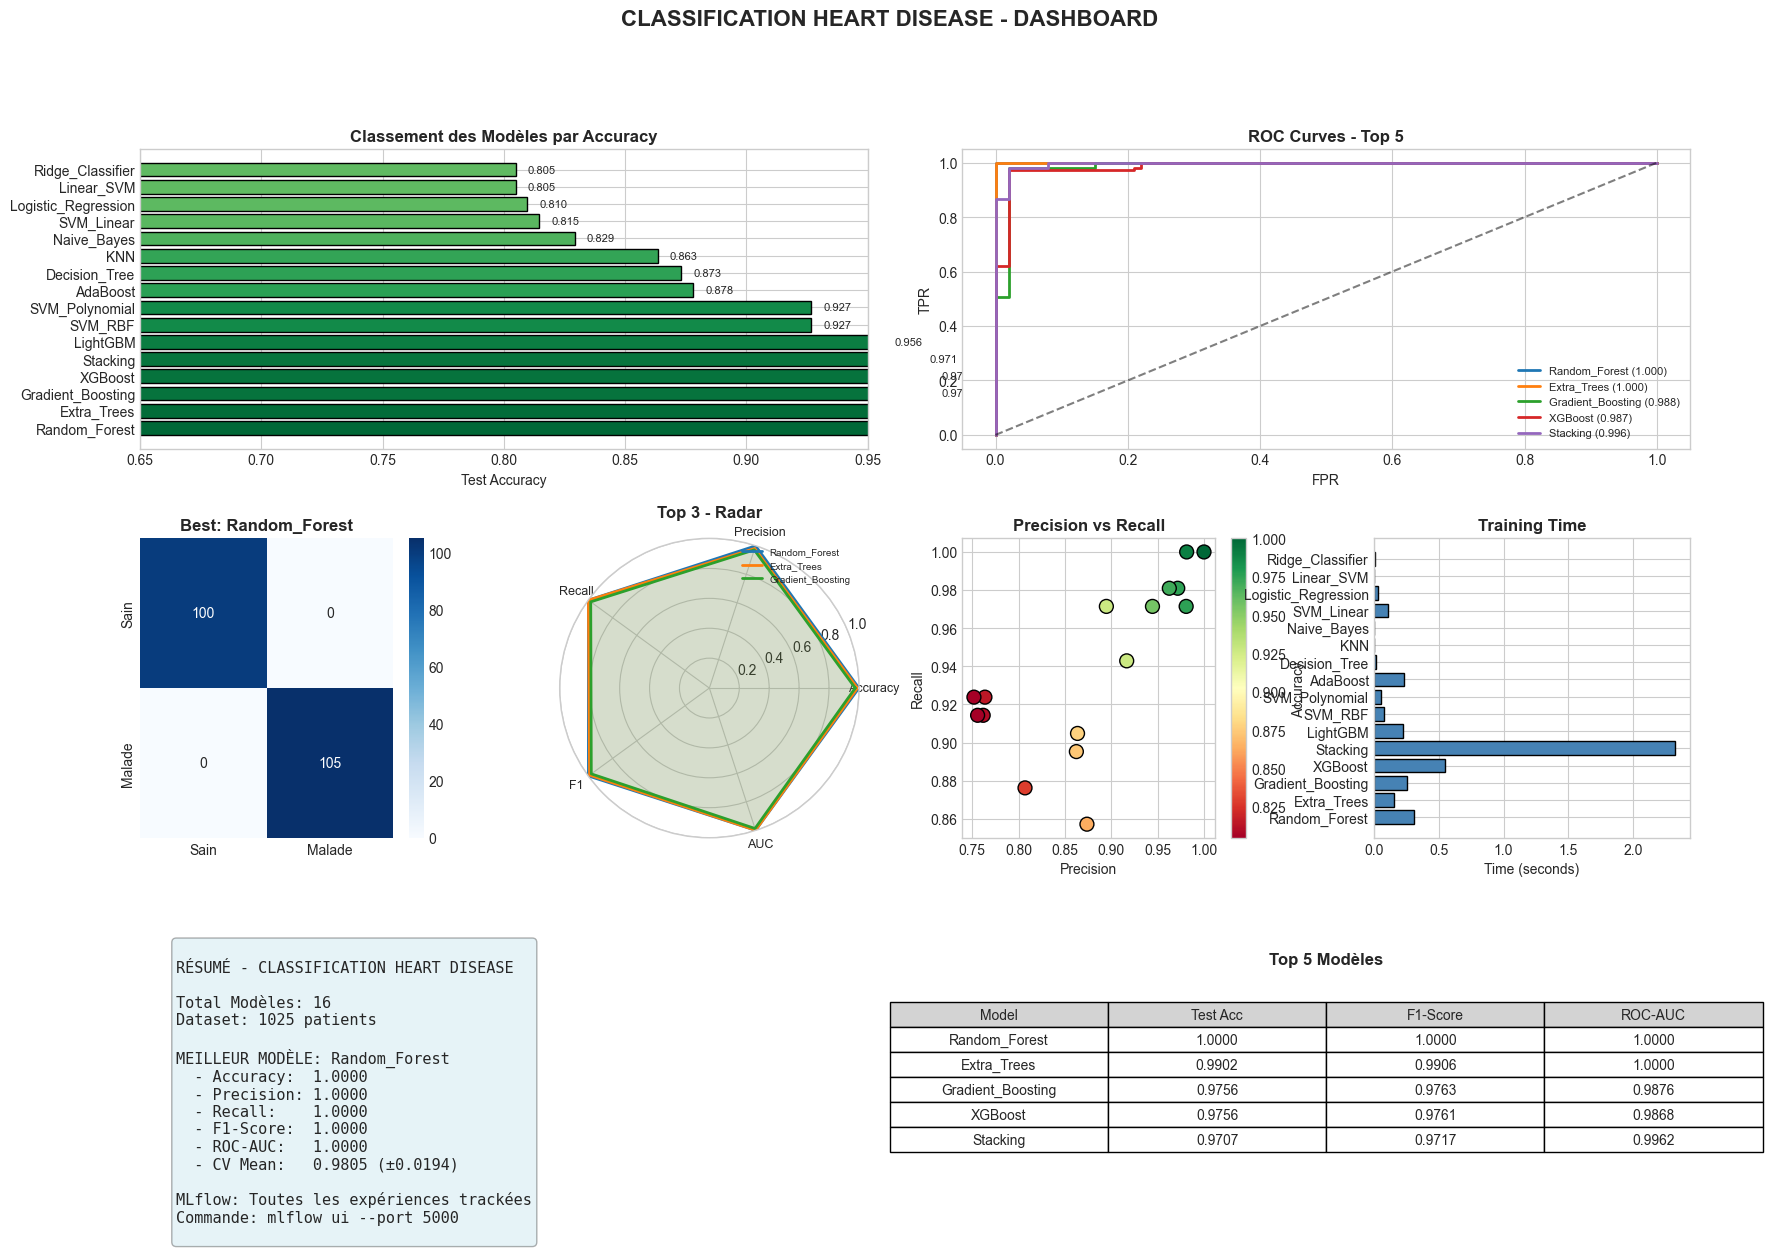

In [18]:
# ============================================================================
# DASHBOARD FINAL
# ============================================================================

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Bar chart - Test Accuracy (top)
ax1 = fig.add_subplot(gs[0, :2])
colors_acc = plt.cm.RdYlGn(comparison_df['Test Acc'].values / comparison_df['Test Acc'].max())
bars = ax1.barh(comparison_df['Model'], comparison_df['Test Acc'], color=colors_acc, edgecolor='black')
ax1.set_xlabel('Test Accuracy')
ax1.set_title('Classement des Modèles par Accuracy', fontweight='bold')
ax1.set_xlim(0.65, 0.95)
for bar, acc in zip(bars, comparison_df['Test Acc']):
    ax1.text(acc + 0.005, bar.get_y() + bar.get_height()/2, f'{acc:.3f}', va='center', fontsize=8)

# 2. ROC curves (top right)
ax2 = fig.add_subplot(gs[0, 2:])
for idx, model_name in enumerate(comparison_df.head(5)['Model']):
    result = next(r for r in all_results if r['model'] == model_name)
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    ax2.plot(fpr, tpr, linewidth=2, label=f"{model_name} ({result['roc_auc']:.3f})")
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('FPR')
ax2.set_ylabel('TPR')
ax2.set_title('ROC Curves - Top 5', fontweight='bold')
ax2.legend(fontsize=8, loc='lower right')

# 3. Confusion matrix best model
ax3 = fig.add_subplot(gs[1, 0])
best_model = comparison_df.iloc[0]['Model']
best_cm = next(r['confusion_matrix'] for r in all_results if r['model'] == best_model)
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Sain', 'Malade'], yticklabels=['Sain', 'Malade'])
ax3.set_title(f'Best: {best_model}', fontweight='bold')

# 4. Metrics radar - Top 3
ax4 = fig.add_subplot(gs[1, 1], projection='polar')
categories = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]
for i, model_name in enumerate(comparison_df.head(3)['Model']):
    row = comparison_df[comparison_df['Model'] == model_name].iloc[0]
    values = [row['Test Acc'], row['Precision'], row['Recall'], row['F1-Score'], row['ROC-AUC']]
    values += values[:1]
    ax4.plot(angles, values, linewidth=2, label=model_name)
    ax4.fill(angles, values, alpha=0.1)
ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories, fontsize=9)
ax4.set_title('Top 3 - Radar', fontweight='bold')
ax4.legend(fontsize=7, loc='upper right')

# 5. Precision vs Recall
ax5 = fig.add_subplot(gs[1, 2])
scatter = ax5.scatter(comparison_df['Precision'], comparison_df['Recall'], 
                       c=comparison_df['Test Acc'], cmap='RdYlGn', s=100, edgecolor='black')
ax5.set_xlabel('Precision')
ax5.set_ylabel('Recall')
ax5.set_title('Precision vs Recall', fontweight='bold')
plt.colorbar(scatter, ax=ax5, label='Accuracy')

# 6. Training time
ax6 = fig.add_subplot(gs[1, 3])
ax6.barh(comparison_df['Model'], comparison_df['Time (s)'], color='steelblue', edgecolor='black')
ax6.set_xlabel('Time (seconds)')
ax6.set_title('Training Time', fontweight='bold')

# 7. Summary text
ax7 = fig.add_subplot(gs[2, :2])
ax7.axis('off')
best = comparison_df.iloc[0]
summary_text = f"""
RÉSUMÉ - CLASSIFICATION HEART DISEASE

Total Modèles: 16
Dataset: {len(df)} patients

MEILLEUR MODÈLE: {best['Model']}
  - Accuracy:  {best['Test Acc']:.4f}
  - Precision: {best['Precision']:.4f}
  - Recall:    {best['Recall']:.4f}
  - F1-Score:  {best['F1-Score']:.4f}
  - ROC-AUC:   {best['ROC-AUC']:.4f}
  - CV Mean:   {best['CV Mean']:.4f} (±{best['CV Std']:.4f})

MLflow: Toutes les expériences trackées
Commande: mlflow ui --port 5000
"""
ax7.text(0.05, 0.95, summary_text, transform=ax7.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 8. Top 5 table
ax8 = fig.add_subplot(gs[2, 2:])
ax8.axis('off')
table_data = comparison_df.head(5)[['Model', 'Test Acc', 'F1-Score', 'ROC-AUC']].copy()
table_data['Test Acc'] = table_data['Test Acc'].apply(lambda x: f'{x:.4f}')
table_data['F1-Score'] = table_data['F1-Score'].apply(lambda x: f'{x:.4f}')
table_data['ROC-AUC'] = table_data['ROC-AUC'].apply(lambda x: f'{x:.4f}')
table = ax8.table(cellText=table_data.values, colLabels=table_data.columns,
                  cellLoc='center', loc='center', colColours=['lightgray']*4)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax8.set_title('Top 5 Modèles', fontweight='bold', y=0.85)

plt.suptitle('CLASSIFICATION HEART DISEASE - DASHBOARD', fontsize=16, fontweight='bold', y=0.98)
plt.savefig('images/classification_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 16. Sauvegarde des Résultats

In [19]:
# ============================================================================
# SAUVEGARDE
# ============================================================================

# Sauvegarder le tableau comparatif
comparison_df.to_csv('classification_results.csv', index=False)
print("\u2705 Résultats sauvegardés: classification_results.csv")

# Sauvegarder les modèles
import joblib
import os
os.makedirs('models', exist_ok=True)

for name, model in trained_models.items():
    joblib.dump(model, f'models/{name}.pkl')
print(f"\u2705 {len(trained_models)} modèles sauvegardés dans models/")

print("\n" + "="*70)
print("CLASSIFICATION TERMINÉE AVEC SUCCÈS !")
print("="*70)
print(f"\nFichiers générés:")
print("  - classification_results.csv")
print("  - classification_comparison.png")
print("  - confusion_matrices.png")
print("  - roc_curves_all.png")
print("  - roc_curves_top5.png")
print("  - feature_importance.png")
print("  - classification_dashboard.png")
print("  - models/*.pkl")

✅ Résultats sauvegardés: classification_results.csv
✅ 16 modèles sauvegardés dans models/

CLASSIFICATION TERMINÉE AVEC SUCCÈS !

Fichiers générés:
  - classification_results.csv
  - classification_comparison.png
  - confusion_matrices.png
  - roc_curves_all.png
  - roc_curves_top5.png
  - feature_importance.png
  - classification_dashboard.png
  - models/*.pkl
